# -- Random Forest Model --

-----

In [1]:
#libs
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [2]:
#dataframe para treino
df = pd.read_csv('df.csv')
df.head()

,Margem EBITDA,Divida liquida/EBTIDA,Indice de liquidez,Ciclo Financeiro,Conversao Ebitda em FCO,Tempo de atuação em anos,Auditorias,PEFIN,Garantia,Seguros,Serasa Score,Target
0,8.44,-0.94,1.94,101,31.81,4,6,0,1,2,900,1
1,3.70,2.23,0.62,99,-10.16,3,0,1,0,0,50,0
2,8.00,1.72,0.59,118,73.67,6,2,2,1,0,200,1
3,3.35,2.19,0.51,51,81.34,2,3,3,2,0,400,1
4,8.61,-0.17,2.40,21,69.11,4,2,0,2,3,550,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48721 entries, 0 to 48720
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Margem EBITDA             48721 non-null  float64
 1   Divida liquida/EBTIDA     48721 non-null  float64
 2   Indice de liquidez        48721 non-null  float64
 3   Ciclo Financeiro          48721 non-null  int64  
 4   Conversao Ebitda em FCO   48721 non-null  float64
 5   Tempo de atuação em anos  48721 non-null  int64  
 6   Auditorias                48721 non-null  int64  
 7   PEFIN                     48721 non-null  int64  
 8   Garantia                  48721 non-null  int64  
 9   Seguros                   48721 non-null  int64  
 10  Serasa Score              48721 non-null  int64  
 11  Target                    48721 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 4.5 MB


## Treinamento do Modelo Random Forest com Grid Search CV

In [4]:
# 1. Separar features (X) e target (y)
X = df.drop(['Target'], axis=1) # Suas features originais
y = df['Target']             

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Dimensões do X_train: {X_train.shape}")
print(f"Dimensões do X_test: {X_test.shape}")

Dimensões do X_train: (34104, 11)
Dimensões do X_test: (14617, 11)


In [5]:
# Exemplo para Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [6]:
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [7]:
print(f"\nMelhores parâmetros para Random Forest: {grid_search_rf.best_params_}")
print(f"Melhor acurácia com Random Forest: {grid_search_rf.best_score_:.4f}")


Melhores parâmetros para Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Melhor acurácia com Random Forest: 0.9754


In [8]:
# Você usaria grid_search_rf.best_estimator_ para fazer previsões agora
best_rf_preds = grid_search_rf.best_estimator_.predict(X_test)
print("\n=== Random Forest Otimizado Evaluation ===")
print(confusion_matrix(y_test, best_rf_preds))
print(classification_report(y_test, best_rf_preds))


=== Random Forest Otimizado Evaluation ===
[[4707   86]
 [ 258 9566]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4793
           1       0.99      0.97      0.98      9824

    accuracy                           0.98     14617
   macro avg       0.97      0.98      0.97     14617
weighted avg       0.98      0.98      0.98     14617



In [9]:
# Os melhores parametros
best_params_rf_commom = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

In [10]:
final_rf_model_commom = RandomForestClassifier(random_state=42, **best_params_rf_commom)
final_rf_model_commom.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [11]:
print("\n--- Avaliando o Random Forest FINAL no conjunto de TESTE ---")
final_rf_preds_c = final_rf_model_commom.predict(X_test)
final_rf_probs_c = final_rf_model_commom.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test, final_rf_preds_c))

print("\nClassification Report:")
print(classification_report(y_test, final_rf_preds_c))


--- Avaliando o Random Forest FINAL no conjunto de TESTE ---
Confusion Matrix:
[[4710   83]
 [ 263 9561]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4793
           1       0.99      0.97      0.98      9824

    accuracy                           0.98     14617
   macro avg       0.97      0.98      0.97     14617
weighted avg       0.98      0.98      0.98     14617



In [12]:
importances = final_rf_model_commom.feature_importances_

# 2. Obter os nomes das features
# Como não usamos PCA, os nomes são as colunas originais de X_common
feature_names = X.columns

# 3. Criar um DataFrame para facilitar a ordenação e visualização
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})


--- Feature Importances do Random Forest (Dataset Comum) ---
                     Feature  Importance
0              Margem EBITDA    0.217113
2         Indice de liquidez    0.199084
1      Divida liquida/EBTIDA    0.197958
6                 Auditorias    0.125590
4    Conversao Ebitda em FCO    0.081839
10              Serasa Score    0.077599
7                      PEFIN    0.024764
9                    Seguros    0.023026
8                   Garantia    0.020878
3           Ciclo Financeiro    0.018470
5   Tempo de atuação em anos    0.013680


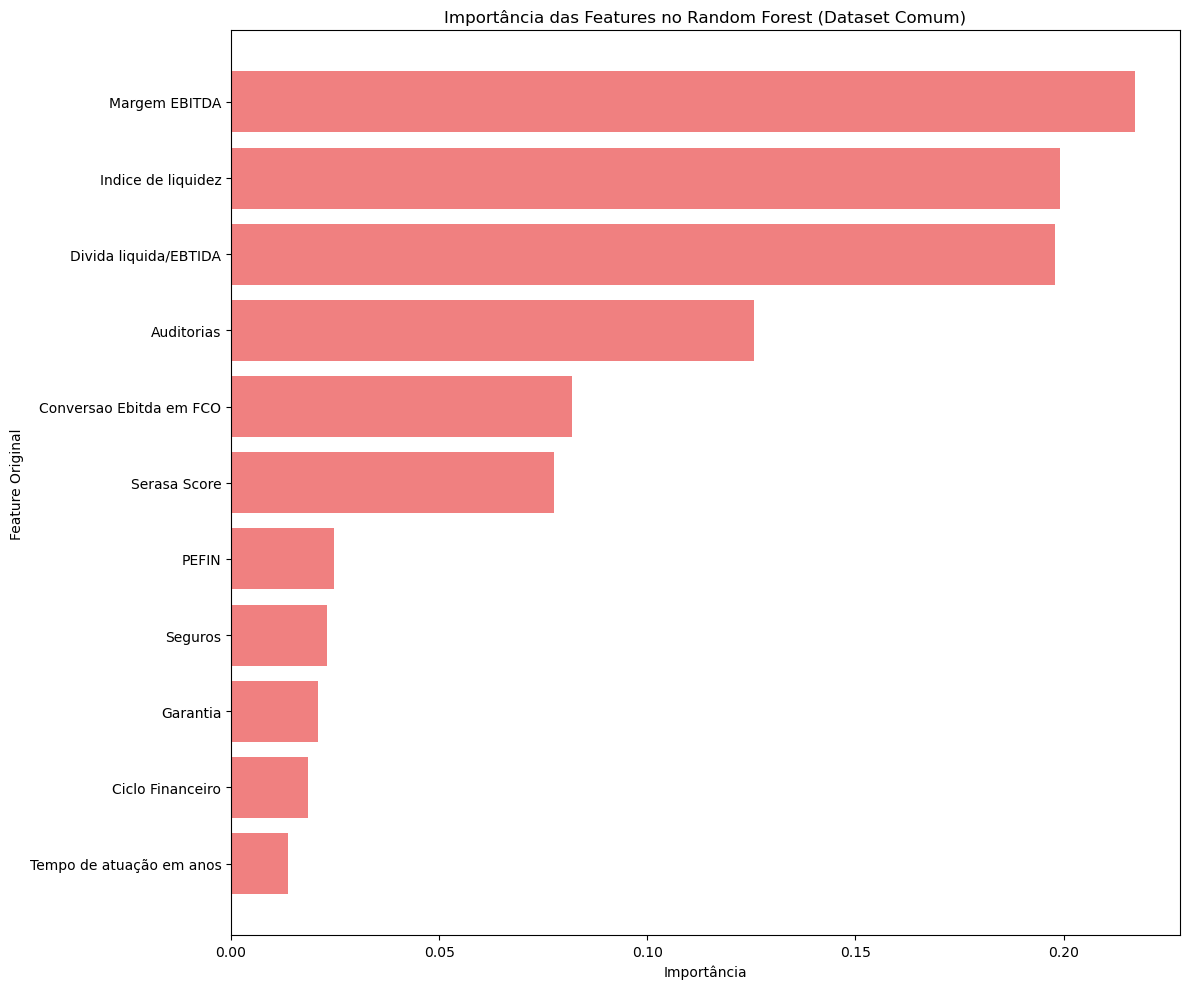

In [13]:
# 4. Ordenar as features por importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Feature Importances do Random Forest (Dataset Comum) ---")
print(feature_importance_df) # Imprime todas as importâncias para verificar

# 5. Plotar as importâncias
plt.figure(figsize=(12, 10)) # Ajuste o tamanho conforme necessário para todas as features
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightcoral')
plt.xlabel('Importância')
plt.ylabel('Feature Original')
plt.title('Importância das Features no Random Forest (Dataset Comum)')
plt.gca().invert_yaxis() # Inverter o eixo y para que o mais importante fique no topo
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.savefig('feature_importances_random_forest_original_data.png', dpi=300, bbox_inches='tight') # Salva a imagem
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ROC AUC Score
roc_auc_rf = roc_auc_score(y_test, final_rf_preds_c)
print(f"\nROC AUC Score para Random Forest: {roc_auc_rf:.4f}")


ROC AUC Score para Random Forest: 0.9780


## Salvar o Modelo em um .pkl

In [16]:
best_rf_model = grid_search_rf.best_estimator_

In [17]:
modelo = 'random_forest_credit_model.pkl'

try:
    joblib.dump(best_rf_model, modelo)
    print(f"Modelo Random Forest salvo com sucesso como '{modelo}'")
    print(f"Tipo do objeto salvo: {type(best_rf_model)}")
except Exception as e:
    print(f"Erro ao salvar o modelo: {e}")

Modelo Random Forest salvo com sucesso como 'random_forest_credit_model.pkl'
Tipo do objeto salvo: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


## Teste de utilização do modelo.
* Desempacotar o .pkl e passar um novo dicionário de dados para o modelo dar uma reposta baseada no aprendizado.

In [18]:
# --- Carregar o Modelo Salvo ---

try:
    modelo = joblib.load('random_forest_credit_model.pkl')
    print("Modelo Random Forest salvo com sucesso!")
    print(f"Tipo do objeto carregado: {type(modelo)}")
except FileNotFoundError:
    print(f"Erro: O arquivo '{modelo}' não foi encontrado.")
    exit()

Modelo Random Forest salvo com sucesso!
Tipo do objeto carregado: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [19]:
indicadores = ['Margem EBITDA', 'Divida liquida/EBTIDA',  'Indice de liquidez',
                  'Ciclo Financeiro', 'Conversao Ebitda em FCO', 'Tempo de atuação em anos', 
                 'Auditorias', 'PEFIN',  'Garantia', 'Seguros',  'Serasa Score', ]

# --- Nova amostra de dados ---

amostra = [
    5.15,       # Margem EBITDA
    -2.23,      # Divida liquida/EBTIDA 
    1.9,        # Indice de liquidez
    30,         # Ciclo Financeiro
    0.2,        # Conversao Ebitda em FCO
    3,          # Tempo de atuação em anos
    1,          # Auditorias 
    1,          # PEFIN 
    1,          # Garantia 
    1,          # Seguros 
    850,        # Serasa Score
]

In [20]:
if len(amostra) != len(indicadores):
    raise ValueError(f"O número de valores na lista ({len(amostra)}) não corresponde ao número de features ({len(indicadores)})")
amostra_df = pd.DataFrame([amostra], columns=indicadores)
print("\nDados da nova empresa para previsão:")
amostra_df


Dados da nova empresa para previsão:


,Margem EBITDA,Divida liquida/EBTIDA,Indice de liquidez,Ciclo Financeiro,Conversao Ebitda em FCO,Tempo de atuação em anos,Auditorias,PEFIN,Garantia,Seguros,Serasa Score
0,5.15,-2.23,1.9,30,0.2,3,1,1,1,1,850


In [21]:
# Prever a classe 0 ou 1 (reprovado ou aprovado)
previsao = modelo.predict(amostra_df)
print(f"\nResultado da Previsão da Amostra (0 = Negar, 1 = Conceder): {previsao[0]}")


Resultado da Previsão da Amostra (0 = Negar, 1 = Conceder): 1


In [22]:
proba = modelo.predict_proba(amostra_df)
print(f"Probabilidade de Negar Crédito (Classe 0): {proba[0][0]*100:.2f}%")
print(f"Probabilidade de Conceder Crédito (Classe 1): {proba[0][1]*100:.2f}%")

Probabilidade de Negar Crédito (Classe 0): 14.50%
Probabilidade de Conceder Crédito (Classe 1): 85.50%
